# Likert Charts in R

Likert charts are a great way to visualize a group of questions on a Likert scale. They were invented by Steve Wexler who is Tableau Zen master and founder of [Data Revelations](https://www.datarevelations.com/). As you'll see the idea is to represent the different distribution of responses by color for each question. The negative responses are diverging to the left, the positive are diverging to the right, and the neutral responses are split along the middle.

Likert charts allow you to visualize the distribution of responses for several questions at a time. If you have a survey with 10 different questions on a likert scale, this is much more effective the creating say 10 different bar charts. However, for Likert charts to be effective the likert scale needs to reflect a consistent direction (i.e. on a 5 point likert scale, "good" responses all need to be 4's and 5's not 1's and 2's). This is generally regarded a best practice in survey development. It's important to realize that these charts don't allow you to visualize any cross correlations. For example, some respondants who score highly in one question may be more likely to score higher/lower in another area or they may be unrelated, but we won't be able to tell from the Likert chart alone.


The purpose of this notebook is to demonstrate the transformation of a common structural representation of survey data, and two different ways for creating a Likert chart with ggplot2 in R. The first way involves splitting a data frame into two, and calling `geom_bar` on both data frames. I learned this methodology from [this blog](http://rnotr.com/likert/ggplot/barometer/likert-plots/). The second way involves a different transformation, only needs a single data frame and utilizes Gantt charts. I will be using data from [this YouTube tutorial on Likert Charts in Tableau](https://www.youtube.com/watch?v=JodWmiIxl2c&t=10s). If you're a new Tableau user you may find it a little fast, but the channel has plenty of videos that can get you up to speed. 

## Loading Libraries

In [6]:
library(tidyverse)
library(scales)
library(ggthemes)
library(readxl)

## Reading in Data
I will read in and print out he first few rows of data. The main data frame, `dat`, containes the responses for 10 questions: Q1-Q10. The scale used is a familiar, intuitive one: 1="Strongly Disagree", 2="Disagree", 3="Neutral", 4="Agree" and 5="Strongly Agreee". The data frame `qmet_dat` contains a data on content of each question.

In [7]:
dat <- read_excel('data/P18-Hotel-Survey-Data.xlsx', sheet = "Responses")

qmet_dat <- read_excel('data/P18-Hotel-Survey-Data.xlsx', sheet='Question Metadata')

In [8]:
head(dat)

ResponseID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5,3,1,3,2,3,2,5,4,5
2,3,2,2,4,1,1,2,4,4,4
3,1,2,2,4,4,4,2,3,5,4
4,3,4,2,4,5,4,5,4,4,3
5,2,2,3,4,5,2,4,5,5,1
6,5,2,4,1,4,3,2,5,5,4


In [9]:
head(qmet_dat)

QuestionID,Category,Question
<chr>,<chr>,<chr>
Q1,Staff,Check-in/Check-out Experience
Q2,Staff,Timeliness of Staff
Q3,Staff,Friendliness of Staff
Q4,Room,Room Cleanliness
Q5,Room,Room Layout
Q6,Room,Room Service


We are going to transform this data so that all scores are arranged into a single column. Additionally, we will create a variable that records the responses according to the scale- Strongly Disagree, Disagree, etc. The name I frequently assigned for my transformed data frames is `tdat`. 

In [20]:
ans_choices <- c("Strongly Disagree", "Disagree", "Neutral", "Agree", "Strongly Agree")

tdat <- 
  dat %>%
  pivot_longer(Q1:Q10, names_to='qid', values_to = 'score') %>%
  mutate(answer = case_when(score==1~ans_choices[1], score==2~ans_choices[2],
                score==3~ans_choices[3], score==4~ans_choices[4],
                score==5~ans_choices[5]),
         neg_score= case_when(score < 3~1, score==3~0.5, score>3~0))


In [28]:
head(tdat)

ResponseID,qid,score,answer,neg_score
<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,Q1,5,Strongly Agree,0.0
1,Q2,3,Neutral,0.5
1,Q3,1,Strongly Disagree,1.0
1,Q4,3,Neutral,0.5
1,Q5,2,Disagree,1.0
1,Q6,3,Neutral,0.5


We need to get cummulative totals for each question. I'll also take this opportunity to bring in the question metadata we read in earlier as `qmet_dat`. This will require some renaming. In addition, I'll also create a variable called `qnum` for question number. While I don't actually use this in the main visualization here, it can be very useful in certain circumstances, e.g. if your audience is familiar with the question order then you may want to sort by question.

In [29]:
qdat <-
  tdat %>%
  group_by(qid) %>%
  summarise(tot_responses = n(),
            tot_neg_scores = sum(neg_score),
            .groups="drop") %>%
  full_join(qmet_dat %>%
              rename(qid = QuestionID), by = 'qid') %>%
  mutate(qnum = as.integer(substring(qid, 2)))%>%
  arrange(qnum)

In [30]:
head(qdat, 10)

qid,tot_responses,tot_neg_scores,Category,Question,qnum
<chr>,<int>,<dbl>,<chr>,<chr>,<int>
Q1,482,365.5,Staff,Check-in/Check-out Experience,1
Q2,482,290.5,Staff,Timeliness of Staff,2
Q3,482,313.5,Staff,Friendliness of Staff,3
Q4,482,81.0,Room,Room Cleanliness,4
Q5,482,110.5,Room,Room Layout,5
Q6,482,197.5,Room,Room Service,6
Q7,482,284.5,Room,Room Design,7
Q8,482,150.5,Value,Price,8
Q9,482,45.5,Value,Amenities,9


All 482 appear to have responded to all 10 questions. Most surveys generally have missing data. This data is for educational purposes so perhaps it was totally simulated. Another possibility is that surveys are submitted through some platform that does not allow for incomplete submissions.

We need to do another transormation on our data, and get the propostion of responses for each question. I will be using this data frame in both methods of visualization.

In [33]:
fdat <- 
  tdat %>%
  group_by(qid, answer) %>%
  summarise(
    score = min(score),
    num =n(), 
    .groups="drop") %>%
  full_join(qdat, by="qid") %>% 
  mutate(prop = num/tot_responses,
         answer = factor(answer, ans_choices)) %>%
  arrange(answer, qnum)

In [34]:
head(fdat)

qid,answer,score,num,tot_responses,tot_neg_scores,Category,Question,qnum,prop
<chr>,<fct>,<dbl>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<dbl>
Q1,Strongly Disagree,1,137,482,365.5,Staff,Check-in/Check-out Experience,1,0.28423237
Q2,Strongly Disagree,1,111,482,290.5,Staff,Timeliness of Staff,2,0.23029046
Q3,Strongly Disagree,1,115,482,313.5,Staff,Friendliness of Staff,3,0.23858921
Q4,Strongly Disagree,1,37,482,81.0,Room,Room Cleanliness,4,0.07676349
Q5,Strongly Disagree,1,37,482,110.5,Room,Room Layout,5,0.07676349
Q6,Strongly Disagree,1,81,482,197.5,Room,Room Service,6,0.16804979


## Create the Visualization- Method 1

We need to split the above data frame into two, because we are going to treat negative and positive scores differently. One data frame will contain all the "Neutral", "Agree" and "Strongly Agree" responses, but the "Neutral" responses will have their proportion of responses, `prop`,  divided by two because we will represent half the "Neutral" responses as "positive" and half as "negative". The other data frame also contain the "Neutral" responses as well as "Disagree" and "Strongly Disagree". We will also make these proportions negative, and divide the the "Neutral" response proportions by two here as well.

In [35]:
positives <- 
  fdat %>%
    filter(score >= 3) %>%
  mutate(prop = if_else(score == 3, prop/2, prop))

negatives <- 
  fdat %>%
  filter(score <= 3) %>%
  mutate(prop = if_else(score == 3, -prop/2, -prop))


Before we produce this chart let's start with a simple example of a stacked bar chart. We'll use these concepts to produce the larger chart. Below, we have a very simple data frame with just three variables.

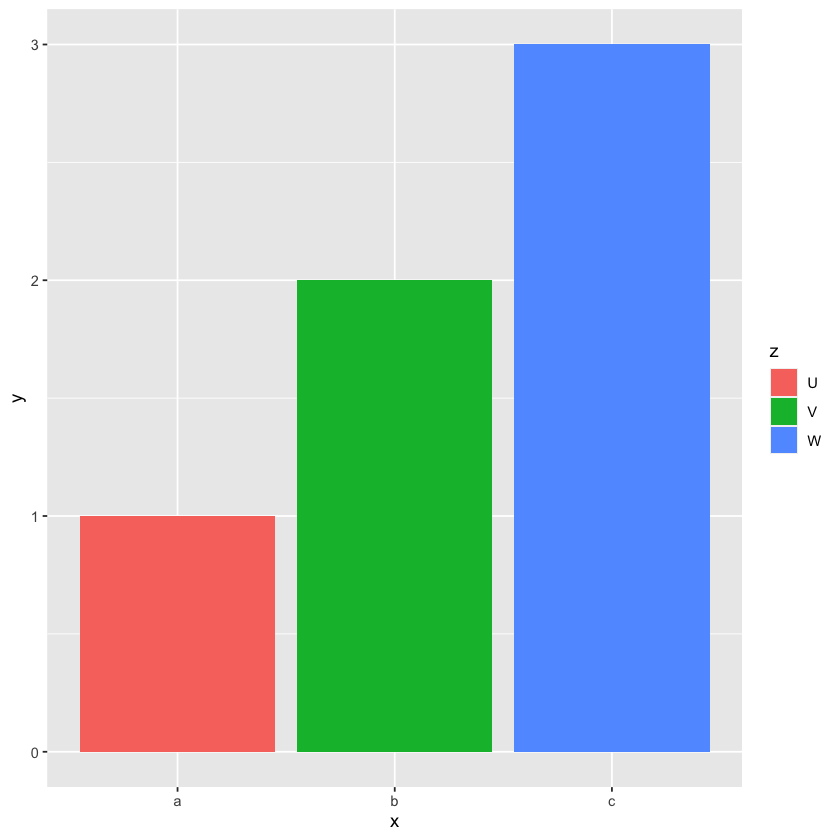

In [36]:
pos_df <- data.frame(x = c('a', 'b', 'c'), y = c(1, 2, 3), z=c('U', 'V', 'W')) 

ggplot()+
    geom_bar(data = pos_df, aes(x, y, fill=z), stat='identity')

You may ask why I chose to supply the data frame inside  <code>geom_bar</code> function rather than inside the <code>ggplot</code> function. The purpose of writing the code this way is to stack the data frames on top of each other. Note the data frame below is very similar only the y values are negative, and the order of 'U' and 'W' in the variable "z" is flipped. 

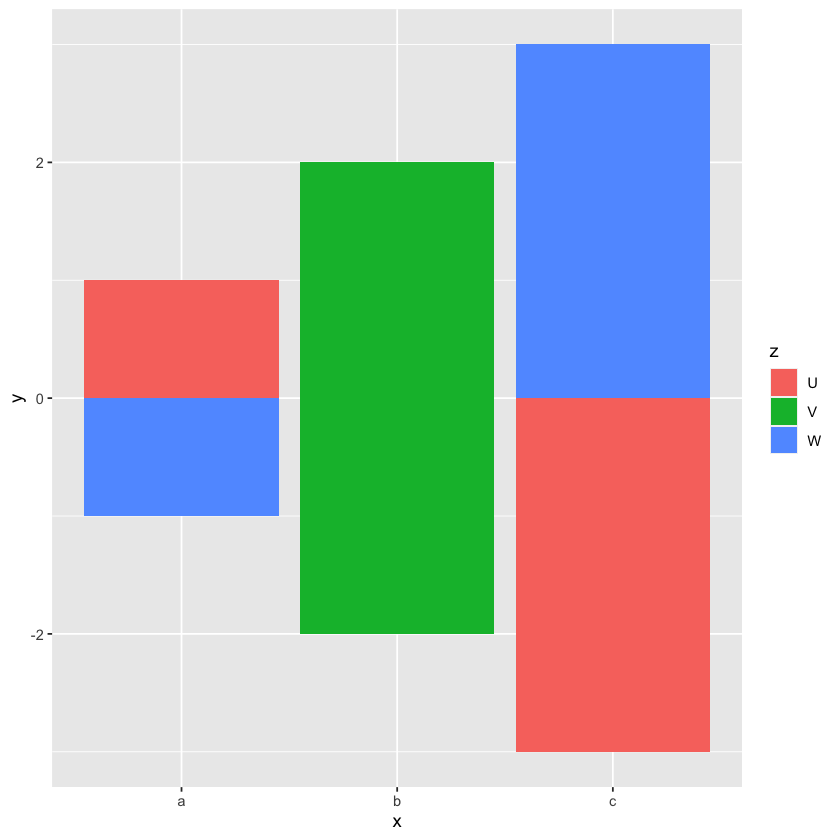

In [38]:
neg_df <- data.frame(x = c('a', 'b', 'c'), y = c(-1, -2, -3), z=c('W','V', 'U')) 

ggplot()+
    geom_bar(data = pos_df, aes(x, y, fill=z), stat='identity')+
    geom_bar(data = neg_df, aes(x, y, fill=z), stat='identity')

This is the fundamental strategy behind our plot. The rest is just the details- font size, colors, etc. 

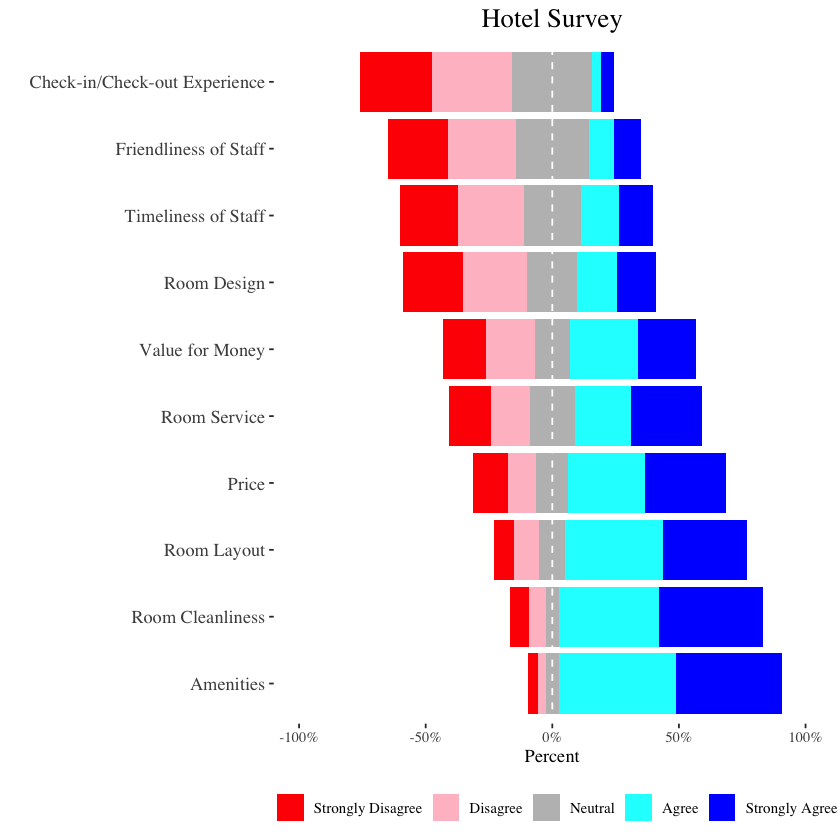

In [40]:
my_cols <- c('red', 'pink', 'gray', 'cyan', 'blue')

ggplot() + 
  geom_bar(data=positives, 
           aes(x = reorder(Question, tot_neg_scores), y=prop, fill=answer), 
           position=position_stack(reverse = TRUE), stat="identity") +
  geom_bar(data=negatives,
           aes(x =reorder(Question, tot_neg_scores), y=prop, fill=answer) , 
           position="stack", stat="identity") +
  scale_fill_manual(values = my_cols, breaks = ans_choices) +
  geom_hline(yintercept = 0, color =c("white"), lty=2)+
  scale_y_continuous(limits = c(-1,1), labels = scales::percent) +
  coord_flip()+
  theme_tufte()+
  labs(x ='', y='Percent', fill='', title = 'Hotel Survey') +
  theme(plot.title = element_text(hjust = 0.5, size = 16),
        legend.position = 'bottom',
        legend.text = element_text(size = 9),
        axis.text.y = element_text(size = 11)) 

## Create the Visualization- Method 2 (Gantt Chart)

This methodolgy follows the Tableau YouTube tutorial mentioned earlier. I wrote a simple function `begin` to implement this method. This function will allow us to compute where each bar begins. This code computes the proportion of respodants who chose "Strongly Disagree", and then adds the subsequent proportions (moves to the right). Notice the use the `cumsum` and `dplyr::lag` functions.

### Transforming these data

In [41]:
begin <- function(x, scores){
  neg <- -x[scores %in% c(1,2)]
  neu <- -1/2*x[scores == 3]
  
  sum(c(neg, neu))
}
  
gantt_dat <- 
  fdat %>%
  group_by(qid) %>%
  mutate(gantt_start = begin(prop, score),
         tot_prop = cumsum(prop),
         prev_tot = dplyr::lag(tot_prop, 1, default = 0),
         begin = gantt_start + prev_tot,
         end = gantt_start + tot_prop) %>%
  select(-gantt_start, - tot_prop, -prev_tot)


### Gantt Charts

If you're not familiar with Gantt charts, they are horizontal bar charts that are a great way to represent overlaps in data. For example, I used to work in math tutoring lab a few hours a day in college, and tutors would gradually pile in throughout the day. Some tutors would cross paths with others, especially during busy times of the day. We also had our specialties for student's assistence. I've mimicked such data, and a simple example below.

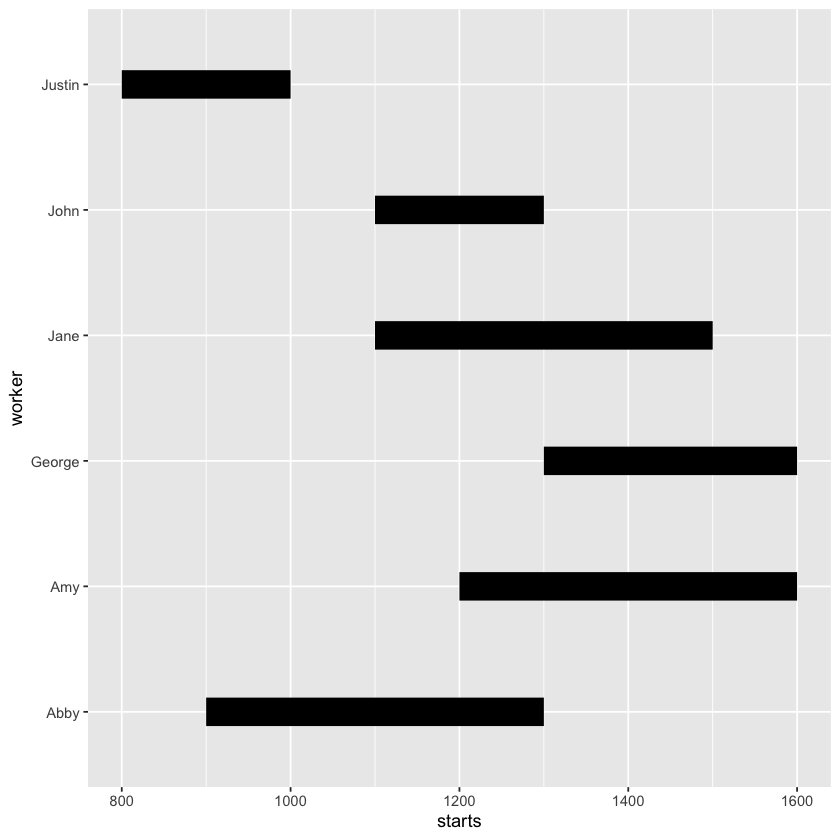

In [42]:
tutor_df <- data.frame(worker = c('Justin', 'Abby', 'Jane', 'John', 'Amy',  'George'),
                 starts = c(0800, 0900, 1100, 1100, 1200, 1300),
                 ends = c(1000, 1300, 1500, 1300, 1600, 1600),
                  expertise = c('Statistics', 'Cal II', 'Cal III', 'Cal III',
                                'Cal I', 'Pre-Cal'))


ggplot(tutor_df, aes(x = starts, xend=ends, y=worker, yend=worker))+
  geom_segment(size=8)


Adding a layer of color can be very useful, especially as you try to distinguish between the categories. For example, we may want tutors with similar expertise to be non-overlapping so we have greater coverage for those courses or we may want to have tutors with expertise overlap with course schedules. This can be done by adding the `col` argument.

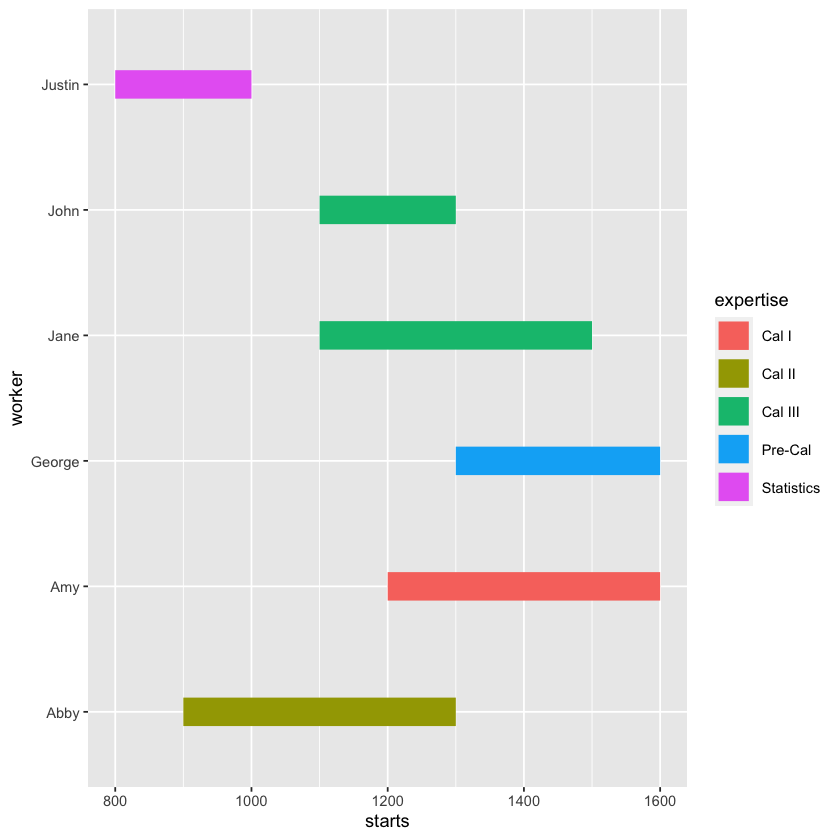

In [43]:
ggplot(tutor_df, aes(x = starts, xend=ends, y=worker, yend=worker, col=expertise))+
  geom_segment(size=8)

In [ ]:
This is the fundamental logic behind this strategy. The rest is just details- specif

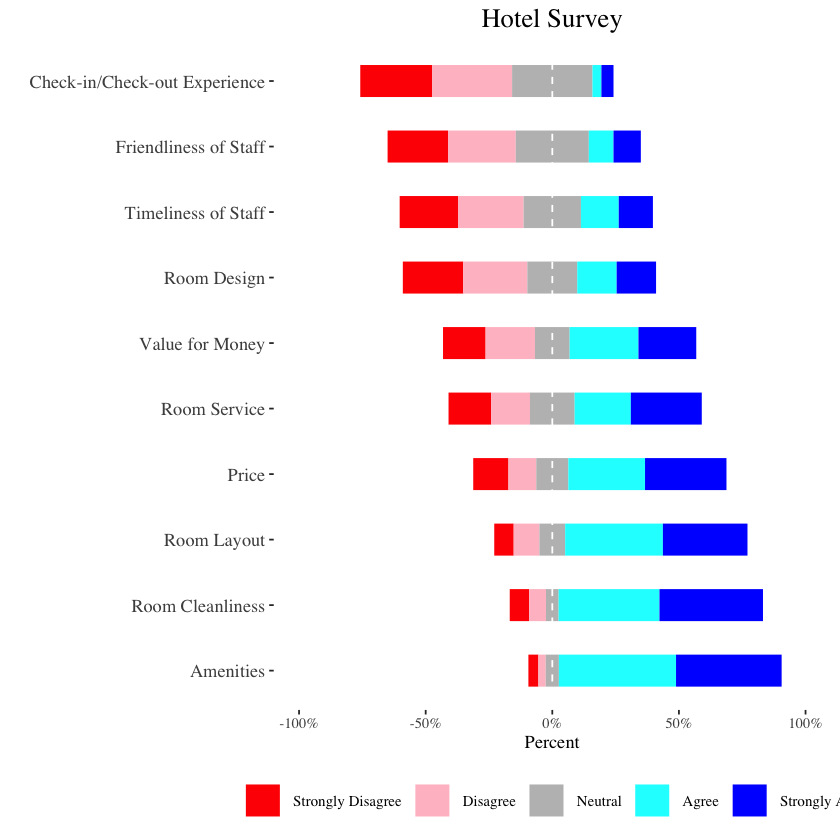

In [44]:
gantt_dat %>%
  ggplot(aes(x=begin, xend=end, 
             y=reorder(Question, tot_neg_scores), yend=reorder(Question, tot_neg_scores),
             col=answer))+
  geom_segment(size=9)+
  geom_vline(xintercept =0, color='white', lty=2)+
  scale_color_manual(values = my_cols, breaks = ans_choices) +
  scale_x_continuous(limits = c(-1,1), labels = scales::percent) +
  theme_tufte()+
  labs(x ='Percent', y='', col='', title = 'Hotel Survey') +
    theme(plot.title = element_text(hjust = 0.5, size = 16),
        legend.position = 'bottom',
        legend.text = element_text(size = 9),
        axis.text.y = element_text(size = 11)) 